# Estimating the fraction of social media comments supporting a policy

You are given two datasets containing answers to "What do you think about a policy?"

## Data Format

|          | verified | lang | C(X) |
|----------|----------|------|------|
| answer 1 |    yes   |  en  | 0.37 |
| answer 2 |    no    |  en  | 0.21 |
| answer 3 |    no    |  es  | 0.89 |
|          |          |      |      |
| answer n |    yes   |  es  | 0.24 |

In [1]:
from typing import Sequence, Dict
from collections import defaultdict, Counter
import random
import math
import numpy as np
import pandas as pd
from scipy import stats

from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from sklearn.linear_model import LogisticRegression

from abc import ABC, abstractmethod
from IPython import display
import krippendorff
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

In [2]:
from util import DataHandler

In [3]:
_SQRT2 = np.sqrt(2)

def hellinger(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / _SQRT2

In [4]:
positive_color = '#3d85c6'
negative_color = '#cc0000'
unknown_color = '#666666'

## 1. Load and profile the dataset

In [5]:
base_dh = DataHandler('data/dataset1_base.csv')
target_dh = DataHandler('data/dataset1_target.csv')

In [6]:
base_dh._p_gt

0.2

In [7]:
target_dh._p_gt

0.7

In [8]:
base_dh.observed_df

,UC(X),GT
0,0.380543,
1,0.309011,
2,0.230878,
3,0.922054,
4,0.086852,
...,...,...
999995,0.939816,
999996,0.166567,
999997,0.182236,
999998,0.222279,


In [9]:
base_dh.count_gt()

0

In [10]:
np.histogram(np.random.rand(10000), np.linspace(0, 1, 11))

(array([1005,  992, 1005,  959,  972, 1005, 1021, 1066,  992,  983]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

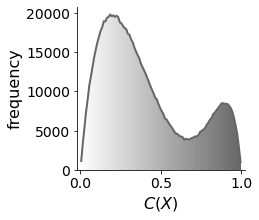

In [11]:
base_dh.plot_cx(color=unknown_color)

## Representation of Joint Distribution

In [12]:
base_dh.get_all_oracle()

In [13]:
base_dh.count_gt()

/Users/siqiwu/Developments/GitWorks/prevalence-estimation-tutorial/code/util.py:174: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return (self.observed_df['GT'].values != '').sum()


AttributeError: 'bool' object has no attribute 'sum'

In [14]:
base_dh.observed_df['GT'].values != ''

/Users/siqiwu/Developments/env/anaconda3/envs/twitter-sampling/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """Entry point for launching an IPython kernel.


True

In [15]:
base_dh.get_oracle_labels(rows=[0,1,2])

In [16]:
base_dh.observed_df

,UC(X),GT
0,0.380543,False
1,0.309011,False
2,0.230878,False
3,0.922054,True
4,0.086852,False
...,...,...
999995,0.939816,True
999996,0.166567,False
999997,0.182236,False
999998,0.222279,False


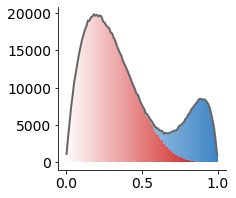

In [19]:
base_dh.plot_joint_dist()

In [18]:
plt.savefig('template.svg')

<Figure size 432x288 with 0 Axes>

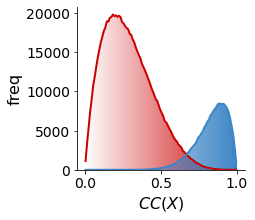

In [19]:
base_dh.plot_class_conditional_density()

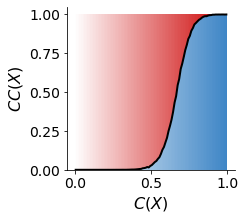

In [20]:
base_dh.plot_calibration_curve()

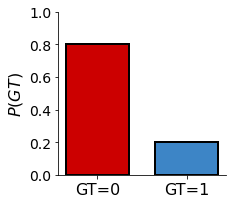

In [21]:
base_dh.plot_dist_gt_labels()

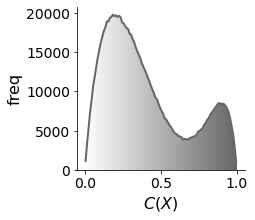

In [22]:
base_dh.plot_dist_classifier_scores()

## Naive approach

In [23]:
from util import DataHandler

In [24]:
base_dh = DataHandler('data/dataset2_base.csv')
target_dh = DataHandler('data/dataset2_target.csv')

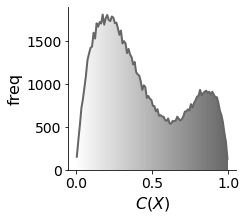

In [25]:
base_dh.plot_dist_classifier_scores()

In [26]:
base_dh.count_gt()

0

## Treat the classifier scores as calibrated scores

0.4242593

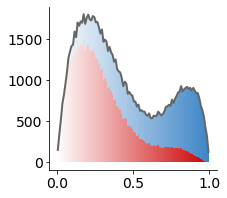

In [27]:
base_dh.get_pcc()

In [28]:
base_dh._p_gt

0.22617

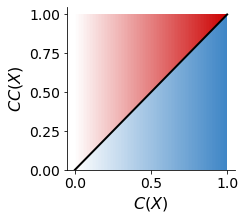

In [29]:
base_dh.plot_idea_calibration_curve()

# Sec 2: Sensitivity of estimate to omitting calibration entirely

In [1]:
from util import DataHandler

In [2]:
base_dh = DataHandler('data/dataset1_base.csv')

In [3]:
base_dh.count_gt()

0

In [4]:
sampeld_rows = base_dh.get_sample_for_labeling(n_item=5000, strategy='random')

In [5]:
base_dh.get_oracle_labels(rows=sampeld_rows)

In [6]:
base_dh.count_gt()

5000

In [7]:
base_dh.sample_df

,UC(X),GT
48,0.952298,True
259,0.409880,False
430,0.350994,False
470,0.695320,True
614,0.485372,False
...,...,...
998911,0.165219,False
999400,0.388382,False
999602,0.775816,True
999922,0.227164,False


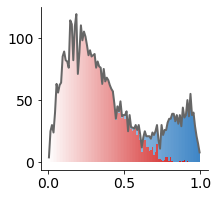

In [8]:
base_dh.plot_joint_dist(df=base_dh.sample_df)

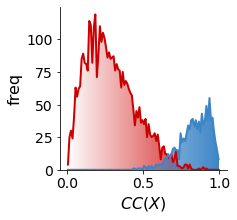

In [9]:
base_dh.plot_class_conditional_density(df=base_dh.sample_df)

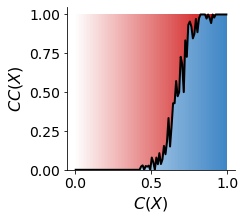

In [10]:
base_dh.plot_calibration_curve(df=base_dh.sample_df)

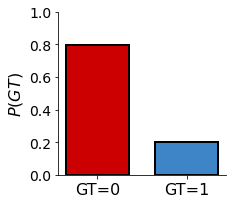

In [11]:
base_dh.plot_dist_gt_labels(df=base_dh.sample_df)

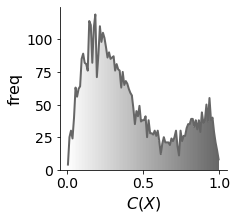

In [12]:
base_dh.plot_dist_classifier_scores(df=base_dh.sample_df)

## uniform on C(X)

In [13]:
base_dh = DataHandler('data/dataset1_base.csv')

In [14]:
base_dh.count_gt()

0

In [15]:
sampeld_rows = base_dh.get_sample_for_labeling(n_item=5000, strategy='uniform on C(X)')

In [16]:
base_dh.get_oracle_labels(rows=sampeld_rows)

In [17]:
base_dh.count_gt()

5000

In [18]:
base_dh.sample_df

,UC(X),GT
0,0.380543,False
1,0.309011,False
2,0.230878,False
3,0.922054,True
4,0.086852,False
...,...,...
12305,0.972467,True
12374,0.982618,True
12393,0.972503,True
12409,0.986022,True


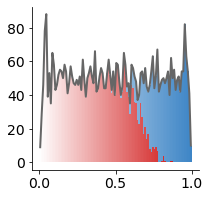

In [19]:
base_dh.plot_joint_dist(df=base_dh.sample_df)

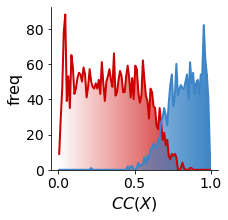

In [20]:
base_dh.plot_class_conditional_density(df=base_dh.sample_df)

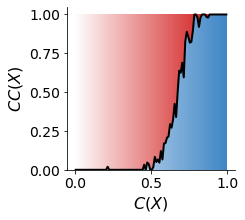

In [21]:
base_dh.plot_calibration_curve(df=base_dh.sample_df)

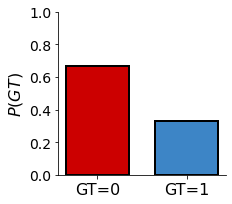

In [22]:
base_dh.plot_dist_gt_labels(df=base_dh.sample_df)

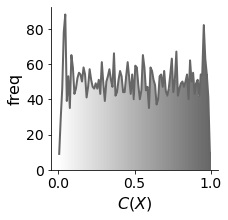

In [23]:
base_dh.plot_dist_classifier_scores(df=base_dh.sample_df)

In [17]:
base_dh.reset_oracle()

In [30]:
base_dh.count_gt()

200

In [19]:
base_dh.observed_df

,UC(X),GT
0,0.320570,
1,0.354232,
2,0.899182,
3,0.273638,
4,0.407449,
...,...,...
9995,0.567049,
9996,0.221406,
9997,0.170131,
9998,0.436968,


In [28]:
base_dh.get_oracle_labels(rows=sampeld_rows)

In [22]:
base_dh.load_features(features=['has_url', 'lang'])

In [29]:
base_dh.observed_df

,UC(X),GT,has_url,lang
0,0.320570,,no,es
1,0.354232,,no,en
2,0.899182,,yes,es
3,0.273638,,no,es
4,0.407449,,no,es
...,...,...,...,...
9995,0.567049,,no,en
9996,0.221406,,yes,es
9997,0.170131,,no,es
9998,0.436968,,yes,es


# Let's first try some approaches

Given: classifier scores UC(X)

Target: P(GT=1)

## 1. Classify and Count (threshold = 0.5)

In [31]:
threshold = 0.5
est_p_cc = base_dh.observed_df[base_dh.observed_df['UC(X)'] > threshold].shape[0] / base_dh.size
est_p_cc

0.3569

In [32]:
base_dh._p_gt

0.2

## 2. Probabilistic Estimator

In [33]:
est_p_pe = base_dh.observed_df['UC(X)'].sum() / base_dh.size
est_p_pe

0.43175002488625985

In [34]:
base_dh._p_gt

0.2

# 3. Now assume we have some budget to label some data

In [35]:
base_dh.count_gt()

200

In [36]:
base_dh.size

10000

In [103]:
# let's label 20% data
num_sample = int(0.1 * base_dh.size)
num_sample

1000

In [104]:
sampeld_rows = base_dh.get_sample_for_labeling(n_item=num_sample, strategy='random')

In [105]:
base_dh.get_oracle_labels(rows=sampeld_rows)

In [115]:
base_dh.count_gt()

4600

In [116]:
labeled_sample = base_dh.get_labeled_sample()

In [117]:
labeled_sample.shape

(4600, 4)

In [118]:
labeled_sample.loc[:, 'GT'] = labeled_sample['GT'].astype('bool')

/Users/siqiwu/Developments/env/anaconda3/envs/twitter-sampling/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [119]:
labeled_sample

,UC(X),GT,has_url,lang
0,0.320570,False,no,es
3,0.273638,False,no,es
6,0.282206,False,yes,es
9,0.370101,False,no,es
14,0.449214,False,no,es
...,...,...,...,...
9992,0.662768,False,yes,en
9994,0.168981,False,yes,en
9996,0.221406,False,yes,es
9998,0.436968,True,yes,es


## 3.1 Learn the optimal threshold by F1

In [120]:
from sklearn.metrics import roc_auc_score, f1_score

In [121]:
roc_auc_score(labeled_sample['GT'].values, labeled_sample['UC(X)'].values)

0.7450367429485582

In [122]:
labeled_sample['UC(X)'].map(lambda x: True if x > 0.3 else False).values

array([ True, False, False, ..., False,  True, False])

In [123]:
best_threshold = 0
best_f1 = 0

for thres in np.linspace(0, 1, 101):
    f1 = f1_score(labeled_sample['GT'].values,
             labeled_sample['UC(X)'].map(lambda x: True if x >= thres else False).values)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thres

best_threshold, best_f1

(0.5, 0.48581422464049745)

## with the best threshold

In [124]:
est_p_cc = base_dh.observed_df[base_dh.observed_df['UC(X)'] >= best_threshold].shape[0] / base_dh.size
est_p_cc

0.3569

## 3.2 learn a platt scaling function

(array([166., 463., 723., 848., 755., 669., 445., 257., 159., 115.]),
 array([9.09108314e-04, 1.00813704e-01, 2.00718299e-01, 3.00622895e-01,
        4.00527490e-01, 5.00432086e-01, 6.00336681e-01, 7.00241277e-01,
        8.00145872e-01, 9.00050468e-01, 9.99955063e-01]),
 <BarContainer object of 10 artists>)

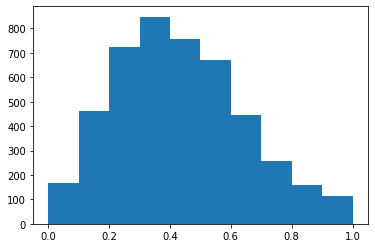

In [125]:
plt.hist(labeled_sample['UC(X)'].values)

In [126]:
from sklearn.linear_model import LogisticRegression

In [127]:
len(labeled_sample['GT'].values)

4600

In [128]:
train_UCX = labeled_sample['UC(X)'].values.reshape(-1, 1)
train_GT = labeled_sample['GT'].values
prob_cali_func = LogisticRegression(fit_intercept=True).fit(train_UCX, train_GT)

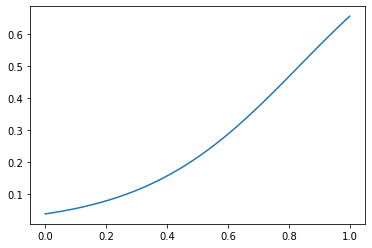

In [129]:
empir_cx_axis = np.linspace(0, 1, 101)
prob_cali_curve = prob_cali_func.predict_proba(empir_cx_axis.reshape(-1, 1))[:, -1]

plt.plot(empir_cx_axis, prob_cali_curve)

In [130]:
items = [(cx, gt) for cx, gt in zip(labeled_sample['UC(X)'].values, labeled_sample['GT'].values)]
num_sample = len(items)

In [138]:
# bootstrap for CI
num_bootstrap = 1000
results = np.zeros((num_bootstrap, len(empir_cx_axis)))
est_result_list = []
target_result_list = []

In [139]:
for idx in range(num_bootstrap):
    bootstrapped_items = random.choices(items, k=num_sample)
    bootstrapped_train_UCX = np.array([cx for cx, gt in bootstrapped_items]).reshape(-1, 1)
    bootstrapped_train_GT = np.array([gt for cx, gt in bootstrapped_items])
    bootstrapped_prob_cali_func = LogisticRegression(fit_intercept=True).fit(bootstrapped_train_UCX, bootstrapped_train_GT)
    bootstrapped_prob_cali_curve = bootstrapped_prob_cali_func.predict_proba(empir_cx_axis.reshape(-1, 1))[:, -1]
    results[idx, :] = bootstrapped_prob_cali_curve.reshape(1, -1)
    
    bootstrapped_cali_prob_scores = bootstrapped_prob_cali_func.predict_proba(base_dh.observed_df['UC(X)'].values.reshape(-1, 1))[:, -1]
    est_pcc = bootstrapped_cali_prob_scores.sum() / len(bootstrapped_cali_prob_scores)
    est_result_list.append(est_pcc)    
    
    bootstrapped_cali_prob_scores = bootstrapped_prob_cali_func.predict_proba(target_dh.observed_df['UC(X)'].values.reshape(-1, 1))[:, -1]
    est_pcc = bootstrapped_cali_prob_scores.sum() / len(bootstrapped_cali_prob_scores)
    target_result_list.append(est_pcc)    

In [140]:
results

array([[0.03577514, 0.03723241, 0.03874666, ..., 0.68286013, 0.69176549,
        0.70053044],
       [0.03099942, 0.03226828, 0.03358728, ..., 0.64964987, 0.65901932,
        0.66826615],
       [0.04218569, 0.04368989, 0.04524519, ..., 0.61418879, 0.62282625,
        0.63138639],
       ...,
       [0.03482603, 0.03621572, 0.0376587 , ..., 0.65787081, 0.66694261,
        0.67589237],
       [0.03248193, 0.03385365, 0.03528119, ..., 0.68966715, 0.69874851,
        0.70767675],
       [0.03563567, 0.03709596, 0.0386137 , ..., 0.687008  , 0.69589902,
        0.70464605]])

In [141]:
np.median(est_result_list), np.percentile(est_result_list, q=2.5), np.percentile(est_result_list, q=97.5)

(0.2006621066217809, 0.19029471318178318, 0.21100593632564454)

In [143]:
target_dh._p_gt

0.7

In [142]:
np.median(target_result_list), np.percentile(target_result_list, q=2.5), np.percentile(target_result_list, q=97.5)

(0.25866823194657484, 0.24502691299573778, 0.2734905822353439)

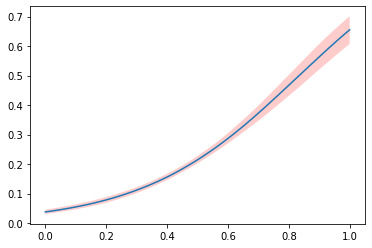

In [136]:
empir_cx_axis = np.linspace(0, 1, 101)

mediaum_prob_cali_curve = np.median(results, axis=0)
lower_prob_cali_curve = np.percentile(results, q=2.5, axis=0)
upper_prob_cali_curve = np.percentile(results, q=97.5, axis=0)

plt.plot(empir_cx_axis, mediaum_prob_cali_curve)
plt.fill_between(empir_cx_axis, lower_prob_cali_curve, upper_prob_cali_curve, facecolor='r', alpha=0.2)

In [55]:
cali_prob_scores = prob_cali_func.predict_proba(base_dh.observed_df['UC(X)'].values.reshape(-1, 1))[:, -1]

In [56]:
cali_prob_scores.sum() / len(cali_prob_scores)

0.20182370293396956

## 3.3 learn the class-conditional density function

In [156]:
# bootstrap for CI
num_bootstrap = 1000
pos_results = np.zeros((num_bootstrap, 10))
neg_results = np.zeros((num_bootstrap, 10))

est_result_list = []
target_result_list = []

In [157]:
for idx in range(num_bootstrap):
    bootstrapped_items = random.choices(items, k=num_sample)
    bootstrapped_train_UCX = np.array([cx for cx, gt in bootstrapped_items]).reshape(-1, 1)
    bootstrapped_train_GT = np.array([gt for cx, gt in bootstrapped_items])
    
    obs_freq, _ = np.histogram(bootstrapped_train_UCX, bins=np.linspace(0, 1, 11))
    pos_freq, _ = np.histogram(bootstrapped_train_UCX[bootstrapped_train_GT == True], bins=np.linspace(0, 1, 11))
    neg_freq, _ = np.histogram(bootstrapped_train_UCX[bootstrapped_train_GT == False], bins=np.linspace(0, 1, 11))
    
    obs_freq = obs_freq / obs_freq.sum()
    pos_freq = pos_freq / pos_freq.sum()
    neg_freq = neg_freq / neg_freq.sum()
    
    pos_results[idx, :] = pos_freq
    neg_results[idx, :] = neg_freq
    
    min_dist = 100
    best_p_p = 0

    for p_p in np.linspace(0, 1, 101):
        dist = hellinger(obs_freq, pos_freq * p_p + neg_freq * (1 - p_p))
        if dist < min_dist:
            min_dist = dist
            best_p_p = p_p
    
    est_result_list.append(best_p_p)
    
    target_obs_freq, _ = np.histogram(target_dh.observed_df['UC(X)'].values, bins=np.linspace(0, 1, 11))
    target_obs_freq = target_obs_freq / target_obs_freq.sum()
    
    min_dist = 100
    best_p_p = 0

    for p_p in np.linspace(0, 1, 101):
        dist = hellinger(target_obs_freq, pos_freq * p_p + neg_freq * (1 - p_p))
        if dist < min_dist:
            min_dist = dist
            best_p_p = p_p

    target_result_list.append(best_p_p)    

In [153]:
np.median(est_result_list), np.percentile(est_result_list, q=2.5), np.percentile(est_result_list, q=97.5)

(0.2, 0.19, 0.21)

In [154]:
np.median(target_result_list), np.percentile(target_result_list, q=2.5), np.percentile(target_result_list, q=97.5)

(0.74, 0.7000000000000001, 0.79)

In [161]:
target_dh._p_gt

0.7

(array([ 45., 112., 190., 215., 190., 180., 112.,  76.,  43.,  37.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

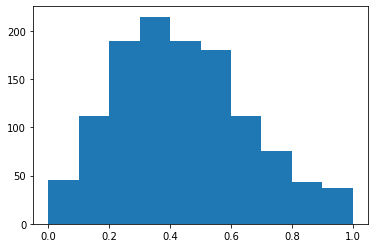

In [57]:
plt.hist(labeled_sample['UC(X)'].values, bins=np.linspace(0, 1, 11))

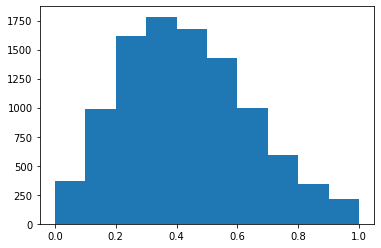

In [58]:
obs_freq, _, _ = plt.hist(base_dh.observed_df['UC(X)'].values, bins=np.linspace(0, 1, 11))

In [59]:
obs_freq /= obs_freq.sum()

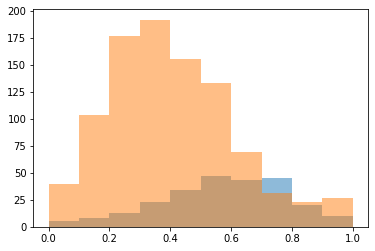

In [60]:
pos_freq, _, _ = plt.hist(labeled_sample[labeled_sample['GT'] == True]['UC(X)'].values, bins=np.linspace(0, 1, 11), alpha=0.5)
neg_freq, _, _ = plt.hist(labeled_sample[labeled_sample['GT'] == False]['UC(X)'].values, bins=np.linspace(0, 1, 11), alpha=0.5)

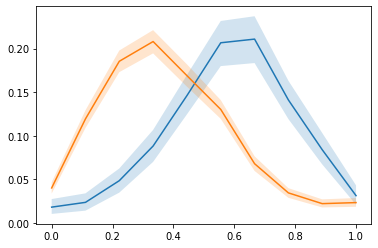

In [159]:
mediaum_pos_density = np.median(pos_results, axis=0)
lower_pos_density = np.percentile(pos_results, q=2.5, axis=0)
upper_pos_density = np.percentile(pos_results, q=97.5, axis=0)

mediaum_neg_density = np.median(neg_results, axis=0)
lower_neg_density = np.percentile(neg_results, q=2.5, axis=0)
upper_neg_density = np.percentile(neg_results, q=97.5, axis=0)

empir_cx_axis = np.linspace(0, 1, 10)

plt.plot(empir_cx_axis, mediaum_pos_density)
plt.fill_between(empir_cx_axis, lower_pos_density, upper_pos_density, alpha=0.2)

plt.plot(empir_cx_axis, mediaum_neg_density)
plt.fill_between(empir_cx_axis, lower_neg_density, upper_neg_density, alpha=0.2)

In [61]:
pos_freq /= pos_freq.sum()
neg_freq /= neg_freq.sum()

In [62]:
_SQRT2 = np.sqrt(2)

def hellinger(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / _SQRT2

In [63]:
min_dist = 100
best_p_p = 0

for p_p in np.linspace(0, 1, 101):
    dist = hellinger(obs_freq, pos_freq * p_p + neg_freq * (1 - p_p))
    if dist < min_dist:
        min_dist = dist
        best_p_p = p_p

In [64]:
best_p_p, min_dist

(0.18, 0.025558533274785394)

# 4. estimate for the target period

## 4.1 PCC

In [65]:
target_cali_prob_scores = prob_cali_func.predict_proba(target_dh.observed_df['UC(X)'].values.reshape(-1, 1))[:, -1]

In [66]:
target_cali_prob_scores.sum() / len(target_cali_prob_scores)

0.2509799776377312

## 4.2 MM

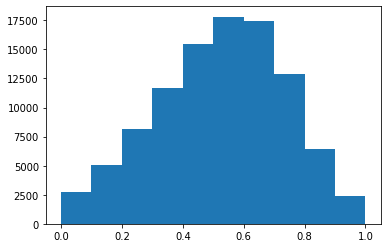

In [67]:
target_obs_freq, _, _ = plt.hist(target_dh.observed_df['UC(X)'].values, bins=np.linspace(0, 1, 11))

In [68]:
min_dist = 10000
best_p_p = 0

for p_p in np.linspace(0, 1, 101):
    dist = hellinger(target_obs_freq, pos_freq * p_p + neg_freq * (1 - p_p))
    if dist < min_dist:
        min_dist = dist
        best_p_p = p_p

In [69]:
best_p_p, min_dist

(0.75, 222.90083316590864)